# MIE 1624 Final Project - Group 1

### Import Libraries 

In [27]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
import csv
import os
import random
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import seaborn as sns

# for dendrogram
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from scipy.cluster.hierarchy import ward, dendrogram

## Data Preparation

### Read job data

In [2]:
df_indeed = pd.read_csv('indeed.csv')
df_work = pd.read_csv('workopolis.csv')
df_monster = pd.read_csv('monster.csv')

### Combine job data

In [3]:
df_job = pd.concat([df_indeed, df_work, df_monster], axis = 0)

# drop duplicates if 'location', 'company' and 'job_title' are the same
df_job.drop_duplicates(subset=['location', 'company','job_title'], keep='last')

# reset index and drop old index columns
df_job = df_job.reset_index()
df_job = df_job.drop(["index","Unnamed: 0"],axis=1)

df_job

,location,company,job_title,salary,job_description,job_url
0,"Mississauga, ON",Hatch,Data Scientist,NaN,Requisition ID: 33710\r\nJob Category: Informa...,NaN
1,"Toronto, ON",Loopio,Data Scientist,NaN,Loopio is a workplace that unleashes learning ...,NaN
2,"Waterloo, ON",McAfee,Data Scientist,NaN,Job Title:\r\nData Scientist\r\n\r\nLocation:\...,NaN
3,"Montréal, QC",EXFO,Data Scientist,NaN,Job title: Data Scientist\r\nDivision/function...,NaN
4,"Montréal, QC",Canadian National Railway,Data Scientist,NaN,Job Summary\r\nThe Data Scientist is responsib...,NaN
...,...,...,...,...,...,...
1667,"Montreal, QC",Fednav Limited,Coordonnateur de projet en TI,NaN,descriptionqui nous sommes | l’entrepriseétabl...,https://job-openings.monster.ca/coordonnateur-...
1668,"Milton, ON",Magna International Inc.,Ecoat Operator,NaN,descriptiongroup description cosma provides a ...,https://job-openings.monster.ca/ecoat-operator...
1669,"Calgary, AB",Calgary Co-operative Association Limited,Bakery Manager,NaN,"descriptionabout us owned by our members, calg...",https://job-openings.monster.ca/bakery-manager...
1670,"Sault Ste. Marie, ON",Ferrovial Services,"Seasonal Equipment Operator - Thessalon, Goula...",NaN,description about us ferrovial services north ...,https://job-openings.monster.ca/seasonal-equip...


### Target skill list

In [4]:
# import skills from 'programming_language.csv'
df_programming_language = pd.read_csv('programming_language.csv')
programming_language_skill = df_programming_language['skill'].to_list()

# import skills from 'ibm_skills_manual.txt'
ibm_skills_manual_txt = open('ibm_skills_manual.txt', 'r')
ibm_skill = ibm_skills_manual_txt.read().splitlines()

# import skills from 'business_skill.txt'
business_skill_txt = open('business_skill.txt', 'r')
business_skill = business_skill_txt.read().splitlines()

# import skills from 'technical_skill.txt'
technical_skill_txt = open('technical_skill.txt', 'r')
technical_skill = technical_skill_txt.read().splitlines()


# combine skills 
skills = ibm_skill + programming_language_skill + business_skill + technical_skill

# lowercase
skills = [skill.lower() for skill in skills]

# remove duplicates
res = [] 
[res.append(x) for x in skills if x not in res] 
skills = res

# add columns for skills
for skill in skills:
      df_job[skill] = np.zeros(len(df_job))

### Extract skills from jobs

In [5]:
for i in range(len(df_job)):
 
    text = str(df_job.iloc[i]['job_description']).strip().lower()
    
    # Preprocessing, replace punctuations, and replace multiple spaces
    text = re.sub(r'\,', ' ', text) 
    text = re.sub('/', ' ', text) 
    text = re.sub(r'\(', ' ', text) 
    text = re.sub(r'\)', ' ', text) 
    text = re.sub(' +',' ',text) 

    for s in skills :
        # This is specifically for C++, escape the ++. Convert C++ to C\+\+
        if any(x in s for x in ['+']):
            skill = re.escape(s)
        else:
            skill = s
    
        matching = re.search(r'(?:^|(?<=\s))' + skill + r'(?=\s|$)',text)
        if matching:
      
            df_job[s][i] = 1
df_job      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,location,company,job_title,salary,job_description,job_url,sampling,probability,distributions,statistical,inferential,visualize,insights,analyze,communicate,characterize,formulate,hypothesis,manipulate,transform,clean data,missing values,outliers,unbalanced data,data normalization,linear algebra,machine learning,modeling techniques,model validation,selection techniques,validate,validated model,big data,a.net,a-0 system,a+,abap,abc,abc algol,acc,...,smarty,spss,standard ml,suneido,thinbasic,transact-sql,vbscript,viml,visual basic .net,whitespace,xen,yacc,z shell,communication,problem solving,consulting,presentation,leadership,documentation,marketing,time management,collaborate,organize,research,excel,sql,tableau,hadoop,power bi,tensorflow,keras,pytorch,theano,caffe,optimization,satistics,modelling,database,natural language processing,nlp
0,"Mississauga, ON",Hatch,Data Scientist,NaN,Requisition ID: 33710\r\nJob Category: Informa...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Toronto, ON",Loopio,Data Scientist,NaN,Loopio is a workplace that unleashes learning ...,NaN,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,"Waterloo, ON",McAfee,Data Scientist,NaN,Job Title:\r\nData Scientist\r\n\r\nLocation:\...,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,"Montréal, QC",EXFO,Data Scientist,NaN,Job title: Data Scientist\r\nDivision/function...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Montréal, QC",Canadian National Railway,Data Scientist,NaN,Job Summary\r\nThe Data Scientist is responsib...,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1667,"Montreal, QC",Fednav Limited,Coordonnateur de projet en TI,NaN,descriptionqui nous sommes | l’entrepriseétabl...,https://job-openings.monster.ca/coordonnateur-...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1668,"Milton, ON",Magna International Inc.,Ecoat Operator,NaN,descriptiongroup description cosma provides a ...,https://job-openings.monster.ca/ecoat-operator...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

## Job skill frequency

### Drop zero-frequency skills

In [6]:
# extract skills only
df_skill = df_job[skills]

# drop skills with 0 appearance
cols = (np.sum(df_skill) != 0)
df_skill_clean = df_skill[cols[cols].index]

### Merge identical meaning columns

In [7]:
def to_one_helper(x): 
    # convert the value larger than 1 to 1
    if x > 1:
        x = 1
    return x

def merge_helper(c1,c2): 
    # merge columns whose names have identical meanings 
    # merge c2 into c1
    df_skill_clean[c1] += df_skill_clean[c2]
    df_skill_clean[c1] = df_skill_clean[c1].apply(lambda x: to_one_helper(x))
    del df_skill_clean[c2]

In [8]:
merge_helper('java','javascript')
merge_helper('machine learning','ml')
merge_helper('natural language processing','nlp')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


### Skill frequency

In [9]:
# count skill appearance
skill_count = df_skill_clean.sum()
skill_count = skill_count.sort_values(ascending=False)
df_skill_count = pd.DataFrame(data=skill_count,columns=["Count"])
df_skill_count.index.name = "Skill"
df_skill_count.head(50)

,Count
Skill,
communication,750.0
machine learning,697.0
python,690.0
research,490.0
sql,448.0
insights,405.0
statistical,345.0
r,322.0
processing,313.0


# Dataframe that only contains skills (for clustering etc.)

In [10]:
df_skill_clean

,sampling,probability,distributions,statistical,inferential,visualize,insights,analyze,communicate,characterize,formulate,hypothesis,manipulate,transform,clean data,outliers,data normalization,linear algebra,machine learning,modeling techniques,model validation,validate,big data,a.net,accent,actionscript,ada,ampl,apt,arc,b,bash,bc,beanshell,c,c++,c#,cg,charm,claire,...,ubuntu,modern programming,timeline,assembly,avenue,ct,falcon,fancy,magic,puppet,revolution,shell,slate,spss,vbscript,yacc,communication,problem solving,consulting,presentation,leadership,documentation,marketing,time management,collaborate,organize,research,excel,tableau,hadoop,power bi,tensorflow,keras,pytorch,theano,caffe,optimization,modelling,database,natural language processing
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

### Skill demand visualization

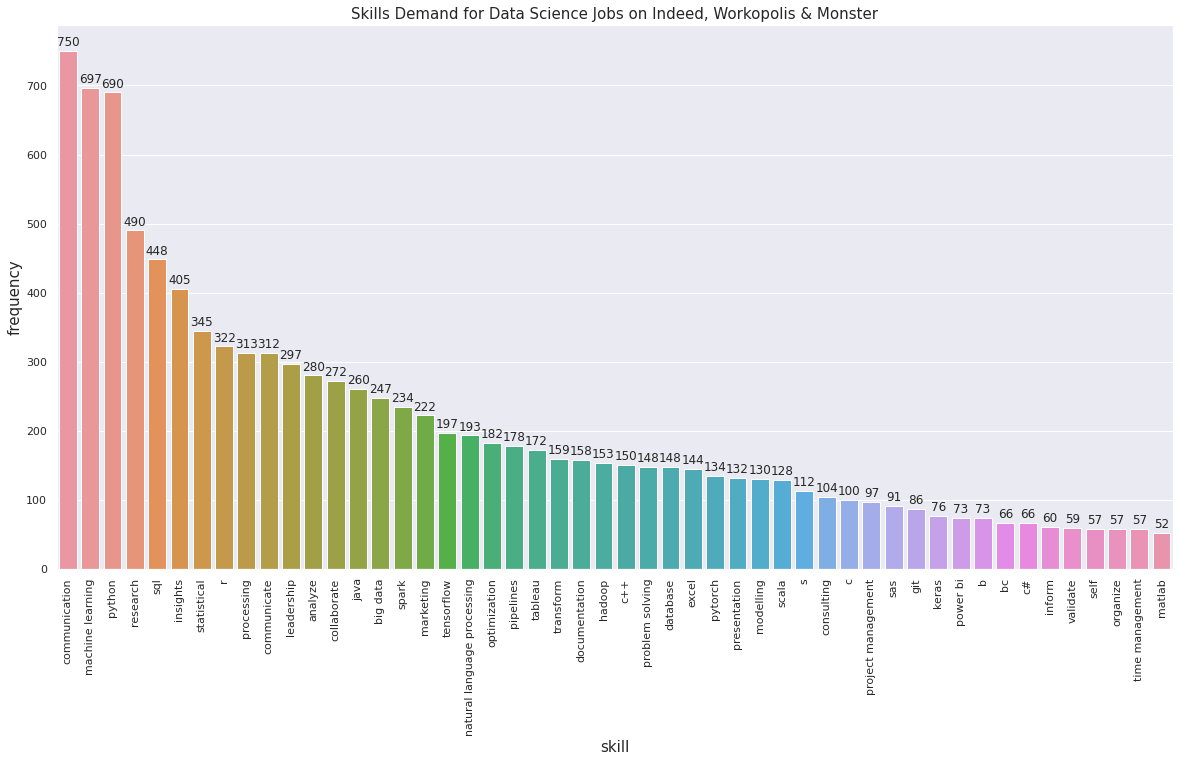

In [11]:
df_skill_count_50 = df_skill_count.head(50)
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x = df_skill_count_50.index, y = df_skill_count_50['Count'])
plt.xlabel('skill', fontsize = 15)
plt.ylabel('frequency', fontsize = 15)
plt.title('Skills Demand for Data Science Jobs on Indeed, Workopolis & Monster', fontsize = 15)
plt.xticks(rotation = 'vertical')

for x,y in zip(np.arange(0,df_skill_count_50.shape[0],1),df_skill_count_50['Count']):
    label = "{:.0f}".format(y)
    plt.annotate(label, (x,y),textcoords='offset points',xytext=(0,5), ha='center') 

plt.show()

### Top 20 skills

In [12]:
skill_1624 = df_skill_count.head(20).index
skill_1624

Index(['communication', 'machine learning', 'python', 'research', 'sql',
       'insights', 'statistical', 'r', 'processing', 'communicate',
       'leadership', 'analyze', 'collaborate', 'java', 'big data', 'spark',
       'marketing', 'tensorflow', 'natural language processing',
       'optimization'],
      dtype='object', name='Skill')

## Clusting and Dendrogram

In [38]:
dendrogram_df = df_skill_clean[df_skill_count_50.index]

corr_matrix = dendrogram_df.corr()
corr_matrix

,communication,machine learning,python,research,sql,insights,statistical,r,processing,communicate,leadership,analyze,collaborate,java,big data,spark,marketing,tensorflow,natural language processing,optimization,pipelines,tableau,transform,documentation,hadoop,c++,problem solving,database,excel,pytorch,presentation,modelling,scala,s,consulting,c,project management,sas,git,keras,power bi,b,bc,c#,inform,validate,self,organize,time management,matlab
communication,1.000000,-0.008901,0.025624,0.021673,0.046276,0.087943,0.089878,0.084054,0.054257,0.015581,0.084248,0.114017,0.052102,-0.035265,-0.070478,-0.013740,0.029835,-0.068510,-0.005920,-0.014050,0.008404,0.015228,0.056073,0.115630,0.014054,-0.051695,0.138070,-0.022809,0.108904,-0.044767,0.137308,0.043501,0.007163,0.042142,0.026635,0.000728,0.089967,0.048666,-0.068470,0.005248,0.019155,-0.027926,-0.034617,-0.003738,-0.031769,0.068662,-0.023646,0.055878,0.128775,-0.016109
machine learning,-0.008901,1.000000,0.552825,0.319105,0.200613,0.272294,0.294307,0.251543,0.265955,0.046511,0.051387,0.088618,0.176212,0.256464,0.191564,0.270814,-0.034119,0.394612,0.347527,0.203039,0.227323,0.033139,0.056728,0.004707,0.240734,0.256688,-0.037138,0.026921,-0.125517,0.313366,0.062861,0.153150,0.185419,0.006361,0.013289,0.149954,-0.054153,0.069863,0.099674,0.246446,-0.032243,0.050869,-0.053035,0.158777,0.032530,0.061834,-0.031829,-0.051884,-0.058569,0.142019
python,0.025624,0.552825,1.000000,0.271670,0.343203,0.331378,0.317088,0.434752,0.248627,0.053771,0.023630,0.121845,0.173636,0.307424,0.185115,0.320163,0.033600,0.353083,0.248461,0.214111,0.266043,0.160035,0.109264,0.015768,0.235360,0.293744,0.003950,0.059550,-0.045146,0.298440,0.060938,0.214821,0.265815,-0.049664,0.030589,0.193304,-0.057319,0.130912,0.145800,0.231167,0.058706,0.100323,-0.032672,0.129540,0.060344,0.083305,-0.003500,-0.010194,-0.063752,0.185741
research,0.021673,0.319105,0.271670,1.000000,0.100008,0.230975,0.243181,0.208711,0.182818,0.119950,0.061747,0.130004,0.146993,-0.000711,0.039304,0.073565,0.065598,0.139660,0.182739,0.167333,0.080243,0.071772,0.082433,0.007619,-0.012936,0.069158,0.030656,0.053786,-0.047778,0.187432,0.074631,0.107473,0.007354,0.032467,0.019159,0.042633,-0.008021,0.077218,-0.013107,0.042437,0.036052,0.061774,0.105662,0.065173,0.094777,0.076269,-0.012343,0.016622,-0.019584,0.043606
sql,0.046276,0.200613,0.343203,0.100008,1.000000,0.313574,0.252146,0.279868,0.100861,0.126178,0.036820,0.162663,0.135819,0.120497,0.277134,0.226933,0.081650,0.063732,0.005439,0.079062,0.193993,0.373019,0.103105,0.081551,0.187367,-0.052886,0.087215,0.258368,0.083834,0.094975,0.073274,0.217695,0.166100,-0.016257,0.073437,-0.021608,-0.017275,0.176305,0.024192,0.068957,0.300304,0.154911,0.002190,0.120089,0.050266,0.067274,-0.046681,-0.039239,-0.061565,0.086095
insights,0.087943,0.272294,0.331378,0.230975,0.313574,1.000000,0.380954,0.297388,0.004236,0.187853,0.080571,0.157688,0.155514,-0.053849,0.099027,0.117974,0.198400,0.027200,0.049151,0.152014,0.080947,0.235909,0.116526,-0.063336,0.077174,-0.040711,0.044973,0.054802,-0.004381,0.079909,0.051906,0.122567,-0.005276,-0.006305,-0.030006,-0.013084,0.020926,0.135119,0.026346,0.050873,0.159301,0.179796,-0.021414,-0.042921,0.108574,0.133988,-0.013900,0.039951,-0.052365,0.099755
statistical,0.089878,0.294307,0.317088,0.243181,0.252146,0.380954,1.000000,0.388135,0.141763,0.131340,0.103312,0.182965,0.083595,0.013669,0.104272,0.105291,0.053104,0.029115,0.125696,0.182438,-0.017866,0.153294,0.121883,0.082851,0.068840,0.093345,0.080450,0.064840,-0.003756,0.040011,0.113799,0.172066,0.031064,0.028908,0.070621,0.020979,-0.012739,0.281592,-0.051823,0.080305,0.108038,0.187598,0.002896,-0.004694,0.124109,0.126770,-0.014346,0.083389,-0.038779,0.215151
r,0.084054,0.251543,0.434752,0.208711,0.279868,0.297388,0.388135,1.000000,0.030023,0.147602,0.082552,0.191226,0.060070,0.075037,0.100159,0.100268,0.108375,0.019105,0.051412,0.126371,0.018294,0.268982,0.162243,-0.007405,0.118541,-0.010018,0.061394,0.018676,0.077

In [39]:
corr_target = abs(corr_matrix)
#relevant_features = cor_target[cor_target<1.0][cor_target>0.5]
relevant_skills = corr_target[corr_target<1.0]

relevant_skills.dropna(how='all', inplace=True)
print('Relevant_skills count = ', len(relevant_skills))

Relevant_skills count =  50


Text(156.5, 0.5, 'Skills')

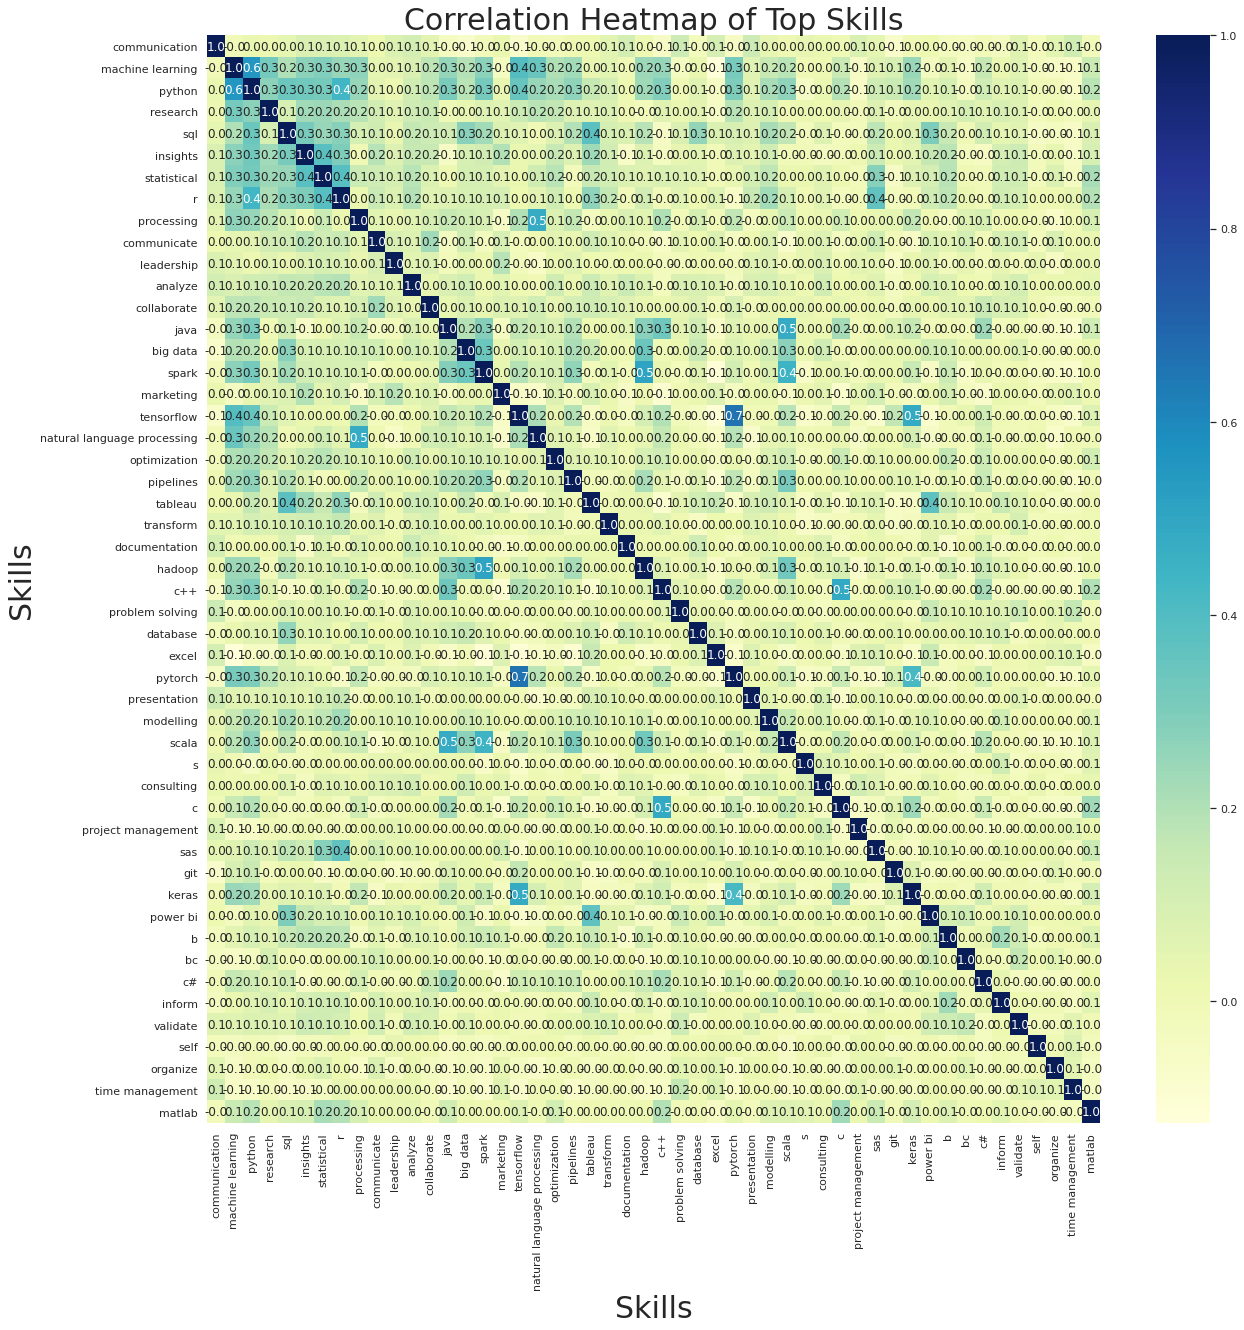

In [40]:
plt.figure(figsize=(20,20))

ax = sns.heatmap(dendrogram_df[relevant_skills.index].corr(),
                 annot = True,
                 fmt = '.1f',
                 cmap = "YlGnBu")
ax.set_title("Correlation Heatmap of Top Skills", fontsize = 30)
ax.set_xlabel("Skills", fontsize = 30)
ax.set_ylabel("Skills", fontsize = 30)

/usr/local/lib/python3.6/dist-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


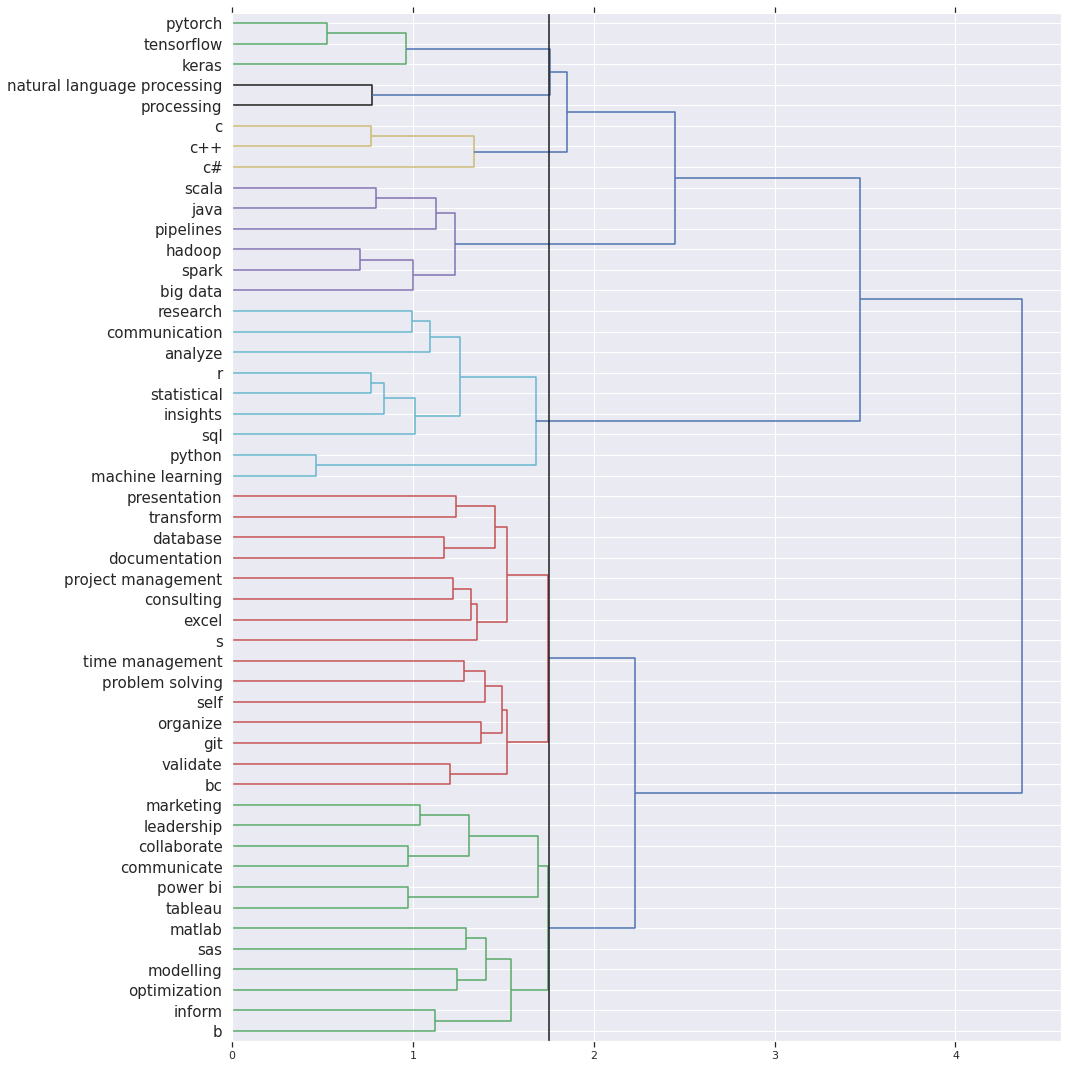

In [45]:
dist = pairwise_distances(dendrogram_df[relevant_skills.index].T, metric = 'cosine')

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances
cutoff_line = 1.75

fig, ax = plt.subplots(figsize=(15, 15)) # set size
ax = dendrogram(linkage_matrix,
                orientation="right",
                labels = dendrogram_df[relevant_skills.index].T.index,
                color_threshold = cutoff_line);
plt.axvline(x = cutoff_line, c='k')
plt.tick_params(\
    axis = 'x',         # changes apply to the x-axis
    which ='both',      # both major and minor ticks are affected
    bottom ='off',      # ticks along the bottom edge are off
    top ='off',         # ticks along the top edge are off
    labelbottom ='off')

plt.yticks(fontsize = '15')
plt.tight_layout() #show plot with tight layout

In [46]:
from scipy.cluster.hierarchy import fcluster
clusters = fcluster(linkage_matrix, cutoff_line, criterion='distance')
clusters

array([3, 3, 3, 3, 3, 3, 3, 3, 6, 1, 1, 3, 1, 4, 4, 4, 1, 7, 6, 1, 4, 1,
       2, 2, 4, 5, 2, 2, 2, 7, 2, 1, 4, 2, 2, 5, 2, 1, 2, 7, 1, 1, 2, 5,
       1, 2, 2, 2, 2, 1], dtype=int32)

In [47]:
np.unique(clusters)

array([1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [55]:
skill_label = pd.DataFrame(relevant_skills.index)
cluster_label = pd.DataFrame(clusters)
final_clustered = pd.concat([skill_label, cluster_label], axis = 1)
final_clustered.columns = ['Skills', 'Cluster']
final_clustered

,Skills,Cluster
0,communication,3
1,machine learning,3
2,python,3
3,research,3
4,sql,3
5,insights,3
6,statistical,3
7,r,3
8,processing,6
9,communicate,1


## Part 1: MIE 1624 Course Curriculum Design

### Original MIE 1624 Course Outline

Introduction to data science and analytics
    1. Data science concepts
    2. Application areas of quantitative modeling
Python programming, data science software
    1. Introduction to Python
    2. Comparison of Python, R and Matlab usage in data science
Basic statistics
    1. Random variables, sampling
    2. Distributions and statistical measures
    3. Hypothesis testing
    4. Statistics case studies in IPython
Overview of linear algebra
    1. Linear algebra and matrix computations
    2. Functions, derivatives, convexity
Optimization
    1. Unconstrained non-linear optimization algorithms
    2. Overview of constrained optimization algorithms
    3. Optimization case studies in IPython
Modeling techniques, regression
    1. Mathematical modeling process
    2. Linear regression
    3. Logistic regression
    4. Regression case studies in IPython
Data visualization and visual analytics
    1. Visual analytics
    2. Visualizations in Python and visual analytics in IBM Watson Analytics
Advanced machine learning
    1. Classification (decision trees)
    2. Advanced supervised machine learning algorithms (Naive Bayes, k-NN, SVM)
    3. Intro to ensemble learning algorithms (Random Forest, Gradient Boosting)
    4. Intro to neural networks and deep learning
    5. Text analytics and natural language processing
    6. Clustering (K-means, Fuzzy C-means, Hierarchical Clustering, DBSCAN)
    7. Dimensionality reduction
    8. Association rules
    9. Overview of reinforcement learning
    10. Machine learning case studies in IPython
Simulation modeling
    1. Random number generation
    2. Monte Carlo simulations
    3. Simulation case studies in IPython
Introduction to Deep Learning
    1. Mathematics of neural networks
    2. Introduction to Deep Learning
    3. Convolutional Neural Networks (CNN)
    4. Recurrent Neural Networks (RNN) and Autoencoders